Interesting link <a href="https://yanirseroussi.com/2015/07/06/learning-about-deep-learning-through-album-cover-classification/">Album Cover CNN </a> <a href="https://github.com/yanirs/bandcamp-deep-learning/">GIT</a>
<br />
Caffe example: <a href="https://github.com/yanirs/bandcamp-deep-learning/blob/master/notebooks/02-caffe-games.ipynb">Yanirs caffe2 pretrained model</a>
<br />
<a href="https://github.com/caffe2/models">Caffe2 models</a>
<br />
<a href="https://github.com/caffe2/tutorials/blob/master/Loading_Pretrained_Models.ipynb">Loading pre-trained models in Caffe2</a>
<br/>
<a href="https://caffe2.ai/docs/tutorial-MNIST.html">CNN Caffe2 Tutorial</a>
<br />
<a href="https://towardsdatascience.com/the-softmax-function-neural-net-outputs-as-probabilities-and-ensemble-classifiers-9bd94d75932">How to use softmax output layer</a>

In [4]:
import numpy as np
from matplotlib import pyplot
import matplotlib.image as mpimg
import os
import pandas as pd
import skimage
import skimage.io as io
import skimage.transform
import operator
from urllib.request import urlopen


from caffe2.python import core, model_helper, net_drawer, workspace, visualize, brew

core.GlobalInit(['caffe2', '--caffe2_log_level=0'])

# Obtaining the Dataset

In [4]:
import requests 
import csv
from multiprocessing.pool import ThreadPool


def _download_image(args):
    session, url, local_path = args[0], args[1], args[2]
    try:
        response = session.get(url)
    except requests.RequestException:
        return False
    if response.status_code != requests.codes.ok:
        return False

    with open(local_path, 'wb') as out:
        out.write(response.content)
    return True

def download_dataset_images(out_dir, dataset_links_tsv='dataset-links.tsv', num_threads=10):
    """Download the dataset images to out_dir, based on the links in dataset_links_tsv.

    dataset_links_tsv is expected to be a tab-separated file with two columns: image url, and local path with format
    <genre>/<album_id>.jpg
    """
#     if os.path.exists(out_dir):
#         raise ValueError('%s already exists' % out_dir)

    session = requests.Session()
    with open(dataset_links_tsv) as fh:
        jobs = []
        genres = set()
        for url, rel_path in csv.reader(fh, delimiter='\t'):
            genres.add(os.path.dirname(rel_path))
            path = os.path.join(out_dir, rel_path)
            if not os.path.exists(path):
                jobs.append((session, url, os.path.join(out_dir, rel_path)))

    for genre in genres:
        genre_path = os.path.join(out_dir, genre)
        if not os.path.exists(genre_path):
            os.makedirs(genre_path)
            
    print('Still needs to download {} covers'.format(len(jobs)))
    pool = ThreadPool(num_threads)
    num_successes = sum(pool.map(_download_image, jobs))
    print('Successfully downloaded %s/%s images' % (num_successes, len(jobs)))
    
download_dataset_images('./img/')

Still needs to download 10000 covers
Successfully downloaded 9753/10000 images


# Caffe2 Analysis

### Initialize workspace

In [3]:
from caffe2.python import models
models = os.path.dirname(models.__file__)
MODEL = 'bvlc_googlenet', 'init_net.pb', 'predict_net.pb', 'ilsvrc_2012_mean.npy', 227
IMAGE_LOCATION = "img/ambient/a4072966.jpg"
codes =  "https://gist.githubusercontent.com/aaronmarkham/cd3a6b6ac071eca6f7b4a6e40e6038aa/raw/9edb4038a37da6b5a44c3b5bc52e448ff09bfe5b/alexnet_codes"

MEAN_FILE = os.path.join(models, MODEL[0], MODEL[3])
if not os.path.exists(MEAN_FILE):
    print("No mean file found!")
    mean = 128
else:
    print ("Mean file found!")
    mean = np.load(MEAN_FILE).mean(1).mean(1)
    mean = mean[:, np.newaxis, np.newaxis]
print("mean was set to: ", mean)

INIT_NET = os.path.join(models, MODEL[0], MODEL[1])
PREDICT_NET = os.path.join(models, MODEL[0], MODEL[2])
print('Init net file: ', INIT_NET)
print('Predict net file: ', PREDICT_NET)

# Read predictor required init, predict files
with open(INIT_NET, "rb") as f:
    init_net = f.read()
with open(PREDICT_NET, "rb") as f:
    predict_net = f.read()
    
# Initialize the workspace predictor
p = workspace.Predictor(init_net, predict_net)

# Set the labels in a class array
with open('codes.txt', 'r') as response:
    class_LUT = []
    for line in response:
        code, result = line.partition(":")[::2]
        code = code.strip()
        result = result.replace("'", "")
        if code.isdigit():
            class_LUT.append(result.split(",")[0][1:])
            


No mean file found!
mean was set to:  128
Init net file:  /usr/lib/python3.7/site-packages/caffe2/python/models/bvlc_googlenet/init_net.pb
Predict net file:  /usr/lib/python3.7/site-packages/caffe2/python/models/bvlc_googlenet/predict_net.pb


### Add functions

In [4]:
def crop_center(img,cropx,cropy):
    y,x,c = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def rescale(img_location, input_height, input_width):
    img = skimage.data.load(img_location)
    aspect = img.shape[1]/float(img.shape[0])

    if aspect > 1:
        # landscape orientation - wide image
        res = int(aspect * input_height)
        imgScaled = skimage.transform.resize(img, (input_width, res))
    elif aspect < 1:
        # portrait orientation - tall image
        res = int(input_width/aspect)
        imgScaled = skimage.transform.resize(img, (res, input_height))
    elif aspect == 1:
        imgScaled = skimage.transform.resize(img, (input_width, input_height))
    
    return imgScaled

# Initialize batch array
def create_img_batch(images):
    height, width = 224, 224
    NCHW_batch = np.zeros((len(images),3,height,width))
    # For each of the images in the list, format it and place it in the batch
    for i, curr_img in enumerate(images):
        img = rescale(curr_img, height, width)
        img = crop_center(img, height, width)
        img = img.swapaxes(1, 2).swapaxes(0, 1)
        img = img[(2, 1, 0), :, :]
        img = img * 255 - mean
        NCHW_batch[i] = img
    print ("Batch Shape: ",NCHW_batch.shape)
    return NCHW_batch

#Parsing the results of one image, creating topN predictions
def parse_results(results, topN):
    index = 0
    highest = 0
    arr = np.empty((0,2), dtype=object)
    arr[:,0] = int(10)
    arr[:,1:] = float(10)
    for i, r in enumerate(results):
        # imagenet index begins with 1!
        i=i
        arr = np.append(arr, np.array([[i,r]]), axis=0)
        if (r > highest):
            highest = r
            index = i 
            
    topN = sorted(arr, key=lambda x: x[1], reverse=True)[:topN]
#     print("Raw top {} results: {}".format(N,topN))
    prediction = []
    for i, p in topN:
        pred = (class_LUT[int(i)], round(p * 100, 2))
        prediction.append(pred)
    return prediction

def get_labels_for_images(images):
    """Returns list of labels that were predicted from given images"""
    batch = create_img_batch(images)
    results = p.run([batch.astype(np.float32)])

    # Turn it into a multi-dimensional array
    results = np.asarray(results)
    # Squeeze out the unnecessary axis
    preds = np.squeeze(results)
    print("Squeezed Predictions Shape, with batch size {}: {}".format(len(images),preds.shape))

    labels = []
    for i, pred in enumerate(preds):
        predictions = parse_results(pred, 10)
#         print('Predictions for img: {}:'.format(images[i]))
        for pred in predictions:
#             print(pred)
            labels.append(pred[0])
    return labels

def add_labels_to_genre(labels, genre):
    for word in punk:
        genre[word] = genre.get(word, 0) + 1
    return genre


## Create output dataframe

In [40]:
df = pd.DataFrame()
batch_size = 100
genres = {f:{} for f in os.listdir('img')}
for genre in genres:
    GENRE_LOCATION = './img/' + genre + '/'
    FOLDER = os.listdir(GENRE_LOCATION)
    for i in range(0, 1000, batch_size):
        images = [os.path.abspath(GENRE_LOCATION + f) for f in FOLDER[i:i+batch_size]]
        batch = create_img_batch(images)
        results = p.run([batch.astype(np.float32)])
        # Turn it into a multi-dimensional array
        results = np.asarray(results)
        # Squeeze out the unnecessary axis
        preds = pd.DataFrame(np.squeeze(results))
        preds['genre'] = genre
        df = pd.concat([df, preds])
# # Describe the results
# for i, pred in enumerate(preds):
#     print("Results for: '{}' :{}".format(images[i], pred))
#     # Get the prediction and the confidence by finding the maximum value 
#     #   and index of maximum value in preds array
#     curr_pred, curr_conf = max(enumerate(pred), key=operator.itemgetter(1))
#     print("\tPrediction: ", curr_pred)
#     print("\tClass Name: ", class_LUT[int(curr_pred)])
#     print("\tConfidence: ", curr_conf)

Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (86, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (79, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (100, 3, 224, 224)
Batch Shape:  (76, 3, 224, 224)
Batch Shape: 

In [44]:
df.genre.unique()

array(['punk', 'hiphop_rap', 'pop', 'dubstep', 'rock', 'soul', 'jazz',
       'metal', 'folk', 'ambient'], dtype=object)

# Network

In [63]:
df = pd.read_csv('output.csv')

In [66]:
df.genre.unique()

array(['punk', 'hiphop_rap', 'pop', 'dubstep', 'rock', 'soul', 'jazz',
       'metal', 'folk', 'ambient'], dtype=object)

In [69]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split

df2 = df[df.genre.isin(['metal', 'folk', 'jazz'])]
# 10 Genres
n_classes = len(df2.genre.unique())
Y = df2.genre
X = df2.iloc[:, 0:1000]
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
labels = list(encoder.inverse_transform(range(0,n_classes)))
# encoded_Y = keras.utils.to_categorical(encoded_Y)
binarized_Y = label_binarize(encoded_Y, classes=range(0,n_classes))
X_train, X_test, Y_train, Y_test = train_test_split(X, binarized_Y, test_size=0.33)
labels
n_classes

3

In [70]:
import tensorflow
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD

model = Sequential()
# Dense(64) is a fully-connected layer with 64 hidden units.
# Model has an input_dimension of 1000 (all the words)
model.add(Dense(1000, activation='relu', input_dim=1000))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(n_classes, activation='softmax'))

sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

model.fit(X_train, Y_train,
          epochs=20,
          batch_size=128)

score = model.evaluate(X_test, Y_test, batch_size=128)

Epoch 1/20
1961/1961 [==============================] - 0s 252us/step - loss: 1.4606 - acc: 0.3381
Epoch 2/20
1961/1961 [==============================] - 0s 104us/step - loss: 1.1058 - acc: 0.3340
Epoch 3/20
1961/1961 [==============================] - 0s 108us/step - loss: 1.1009 - acc: 0.3417
Epoch 4/20
1961/1961 [==============================] - 0s 100us/step - loss: 1.0993 - acc: 0.3371
Epoch 5/20
1961/1961 [==============================] - 0s 101us/step - loss: 1.1003 - acc: 0.3371
Epoch 6/20
1961/1961 [==============================] - 0s 95us/step - loss: 1.0980 - acc: 0.3386
Epoch 7/20
1961/1961 [==============================] - 0s 98us/step - loss: 1.0996 - acc: 0.3325
Epoch 8/20
1961/1961 [==============================] - 0s 99us/step - loss: 1.0985 - acc: 0.3386
Epoch 9/20
1961/1961 [==============================] - 0s 101us/step - loss: 1.0991 - acc: 0.3238
Epoch 10/20
1961/1961 [==============================] - 0s 107us/step - loss: 1.0988 - acc: 0.3248
Epoch 11/20


In [74]:
score = model.evaluate(X_test, Y_test, batch_size=128)
score

967/967 [==============================] - 0s 40us/step


[1.0990530358475268, 0.3236814892649527]

In [71]:
y_score = model.predict(X_test, batch_size=128)

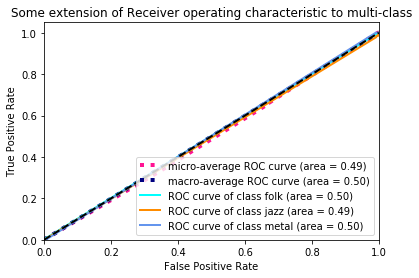

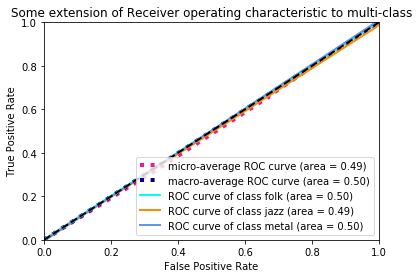

In [72]:
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc

# Plot linewidth.
lw = 2

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(Y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


plt.figure(2)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(labels[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()


### Test image conversion

In [34]:


img, imgBGR = get_resized(TEST_IMG, 224, 224)
pyplot.figure()
pyplot.subplot(1,2,1)
pyplot.imshow(img)
pyplot.axis('on')
pyplot.title('Original image = RGB')

pyplot.figure()
for i in range(3):
    # For some reason, pyplot subplot follows Matlab's indexing
    # convention (starting with 1). Well, we'll just follow it...
    pyplot.subplot(1, 3, i+1)
    pyplot.imshow(imgBGR[i])
    pyplot.axis('off')
    pyplot.title('BGR channel %d' % (i+1))
    
imgCropped = imgBGR[np.newaxis, :, :, :].astype(np.float32)
print('Final input shape is:', imgCropped.shape)

NameError: name 'get_resized' is not defined

## Look through the downloaded Albums

In [69]:
class Album:
    
    def __init__(self, path, infos):
        self.path = path
        self.name = infos[0]
        self.genre = infos[1]
        self.label = infos[2]
        self.year = infos[3]

def read_files(file_list):
    albums = []
    fucked = []
    for i in range(len(file_list)):
        file_name = file_list[i]
        split = file_name.split('-')
        if file_name.count('-') >= 4:
            print('FUCK: ', file_name)
            fucked.append(file_name)
        else:
            albums.append(Album(os.path.abspath(file_name), split))
    return albums, fucked
    

def explore_files():
    current_folder_filename_list = os.listdir("./data") # Change this PATH to traverse other directories if you want.
    albums, fucked = [], []
    if current_folder_filename_list != None:
        print("%s files were found under current folder. " % len(current_folder_filename_list))
        albums, fucked = read_files(current_folder_filename_list)
    return albums, fucked

albums, fucked = explore_files()
genres = [a.genre for a in albums]

unique_genres = sorted(set(genres))
print("We start with {} genres which are definitely too many labels for a CNN at this point.".format(len(unique_genres)))

4064 files were found under current folder. 
FUCK:  TM404-Dub Techno-Kontra-Musik-2013.jpg
FUCK:  Knee-Deep In The North Sea-Jazz-Real World-2007.jpg
FUCK:  ZGMF-X19A-UK Bass-Infinite Machine-2015.jpg
FUCK:  Singles 93-03-Big Beat-Virgin-2003.jpg
FUCK:  Everywhere at the end of time - Stage 4-Dark Ambient-History Always Favours The Winners-2018.jpg
FUCK:  Acquiescence-Downtempo-Non-Projects-2012.jpg
FUCK:  32 Zel  Planet Shrooms-Hip-Hop--2015.jpg
FUCK:  Jenny Death-Hip-Hop-Harvest Records-2015.jpg
FUCK:  Re-Animations EP-Footwork-Astrophonica-2013.jpg
FUCK:  Czarface meets Metal Face-Hip-Hop-Silver Age-2018.jpg
FUCK:  And. IV [Inertia]-Glitch-Raster-Noton-2012.jpg
FUCK:  EP1 Drum Talking-Dub-One-Handed Music-2011.jpg
FUCK:  Alas Rattoisaa Virtaa-Neo-Psychedelia-Dekorder-2014.jpg
FUCK:  Old-Hip-Hop-Fool's Gold Records-2013.jpg
FUCK:  Inner Treaty-Neo-Psychedelia-Sun Ark Records-2012.jpg
FUCK:  volume 1 flick your tongue against your teeth and describe the present.-Hip-Hop--2017.png
FUCK

# Clarifai Analysis

In [9]:
from clarifai.rest import ClarifaiApp
app = ClarifaiApp()

m = app.models.get('aaa03c23b3724a16a56b629203edc62c')

# app.tag_images('http://assets.rollingstone.com/assets/images/list/0e099b2214b1673fc76c6c60257b88aefe571def.jpg')

In [30]:
def get_albums_img(main_folder):
    img_folder_list = os.listdir(main_folder) # Change this PATH to traverse other directories if you want.
    albums = {}
    for folder in img_folder_list:
        print(folder)
        if folder not in albums.keys():
            albums[folder] = []
        # Retrieve images for this album
        images = os.listdir(main_folder + '/' +folder)
        for image in images:
            if image not in albums[folder]:
                albums[folder].append(image)
                
    return albums

albums = get_albums_img("./img")

def get_absolute_image_path(genre, image):
    return os.path.abspath("./img/{}/{}".format(genre, image))

hiphop_rap
dubstep
rock
ambient
pop
punk
jazz
folk
soul
metal


In [32]:
tryout = albums['ambient'][0:1]
for img in tryout:
    path = get_absolute_image_path('ambient', img)
    tags = m.predict('http://assets.rollingstone.com/assets/images/list/0e099b2214b1673fc76c6c60257b88aefe571def.jpg')

/home/krulvis/PycharmProjects/AlbumAnalyser/img/ambient/a1604573766.jpg
